In [1]:
from SimplePINN import *
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style(context='talk', fscale=1.6, spines=False, grid=False)
import time

## Setting-up the Model

In [2]:
dataset = PINNDataset(interiorSize=2000, boundarySize=1000)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)
numBatches = len(dataloader)
nEpoch = 5000
lr = 1e-3

In [3]:
model = basePIMLP([2, 64, 64, 1], expansionOrder=16, activation=nn.LeakyReLU(0.1)).to(device) #torch.load('Laplace1.pth)
opt = torch.optim.Adam(model.parameters(), lr)
sched = torch.optim.lr_scheduler.StepLR(opt, 1, 0.99)
lrHistory = np.zeros(nEpoch)
lossHistory = np.zeros(nEpoch)
print("Model is Ready! Number of Parameters: {}".format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

Model is Ready! Number of Parameters: 4451


## Physics of the problem
##### Laplace Equation $ (\frac{\partial ^2 \phi}{\partial x^2} + \frac{\partial ^2 \phi}{\partial y^2} = 0) $ <br> BC 1: $\phi$(x, 0) = +sin(2$\pi$x) <br> BC 2: $\phi$(x, 1) = -sin(2$\pi$x) <br> BC 3: $\phi$(0, y) = 0 <br> BC 4: $\phi$(1, y) = 0

In [4]:
def equation(x):
    return model.hessian(x, laplacian=True).sum(-1).squeeze()
def boundary(x):
    y = model(x).squeeze()
    z = torch.zeros(x.size(0), device=x.device)
    z = torch.where(x[:, 0] == 0, y - torch.sin(2 * np.pi * x[:, 1]), z)
    z = torch.where(x[:, 0] == 1, y + torch.sin(2 * np.pi * x[:, 1]), z)
    z = torch.where((x[:, 1] == 0) + (x[:, 1] == 1), y, z)
    return z

### Training Loop

In [5]:
model = model.to(device)
patience = 10
time_ = time.time()
for ii in range(nEpoch):    
    epochLoss = 0
    time1 = time.time()
    for jj, x in enumerate(dataloader):
        opt.zero_grad(set_to_none=True)
        x = x.to(device)
        loss = (equation(x)**2 + boundary(x)**2).mean()
        loss.backward()
        opt.step()
        epochLoss += loss.detach().cpu().numpy()
        time2 = time.time() - time1
        rt = (numBatches - jj - 1) * time2 / (jj+1)
        if jj % 10 == 9:
            print('[Epoch {:05d}/{:05d}, Batch {:05d}/{:05d}, Remaining Time: {:02d}:{:02d}, Rate = {:.4f}] : Training Loss = {:.8f}'.format(ii+1, nEpoch, jj+1, numBatches, int(rt//60), int(rt%60), (jj+1)/time2, epochLoss/(jj+1)), end='\r', flush=True)    
    lossHistory[ii] = epochLoss / numBatches
    lrHistory[ii] = sched.get_last_lr()[0]
    if (lossHistory[ii] > lossHistory[ii-patience: ii]).all(): sched.step()
    torch.cuda.empty_cache()
    if ii%100 == 99:
        print('[Epoch {:05d}/{:05d}] : Training Loss = {:.8f} ---------------------------------------------------------'.format(ii+1, nEpoch, lossHistory[ii]))


[Epoch 00100/05000] : Training Loss = 0.08370365 ---------------------------------------------------------
[Epoch 00200/05000] : Training Loss = 0.02898076 ---------------------------------------------------------
[Epoch 00300/05000] : Training Loss = 0.01131432 ---------------------------------------------------------
[Epoch 00400/05000] : Training Loss = 0.00347914 ---------------------------------------------------------
[Epoch 00500/05000] : Training Loss = 0.00116426 ---------------------------------------------------------
[Epoch 00600/05000] : Training Loss = 0.00061774 ---------------------------------------------------------
[Epoch 00700/05000] : Training Loss = 0.00030139 ---------------------------------------------------------
[Epoch 00800/05000] : Training Loss = 0.00021138 ---------------------------------------------------------
[Epoch 00900/05000] : Training Loss = 0.00013329 ---------------------------------------------------------
[Epoch 01000/05000] : Training Loss =

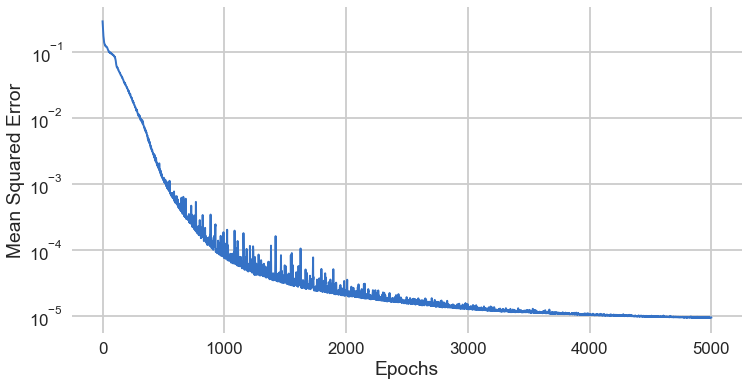

In [6]:
plt.figure(figsize=(12, 6))
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.yscale('log')
plt.grid(True)
plt.plot(lossHistory)

In [7]:
x = torch.linspace(0, 1, 128)
x1, x2 = torch.meshgrid(x, x, indexing='ij')
x = torch.cat((x1.reshape(-1, 1), x2.reshape(-1, 1)), dim=-1)

In [8]:
model = model.to('cpu')

In [9]:
y = model(x).detach().cpu().reshape(128, 128)

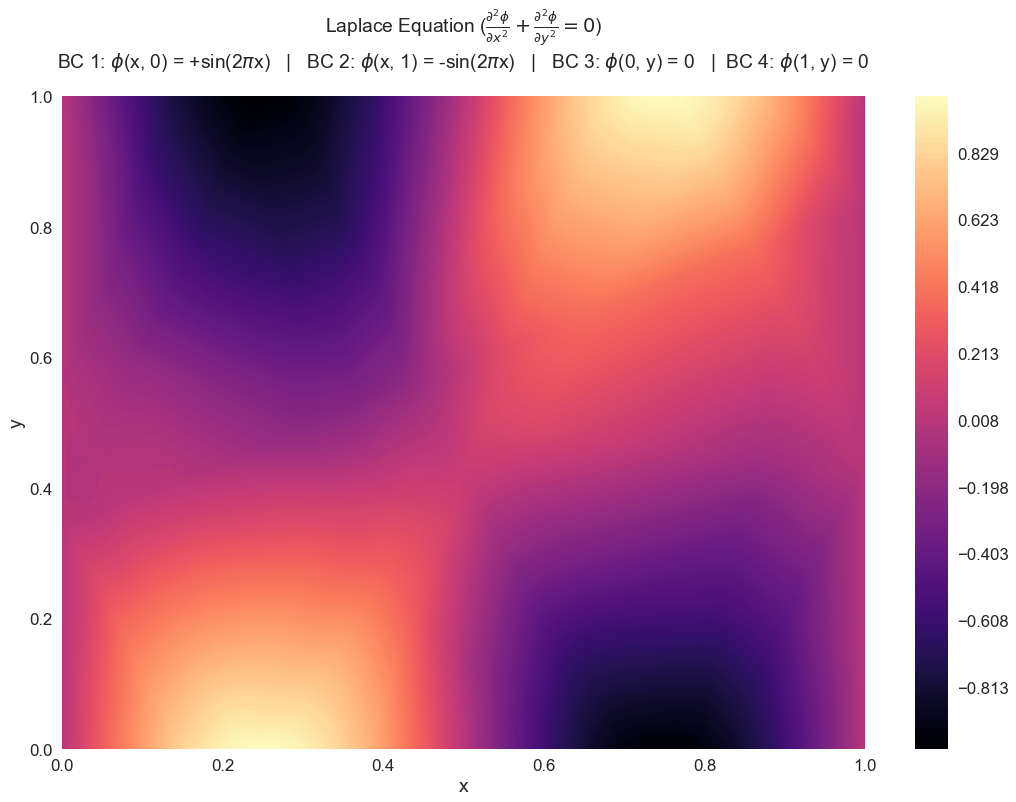

In [11]:
plt.figure(figsize=(18, 12))
plt.title(r"Laplace Equation ($\frac{\partial ^2 \phi}{\partial x^2} + \frac{\partial ^2 \phi}{\partial y^2} = 0$)""\n"
          r"BC 1: $\phi$(x, 0) = +sin(2$\pi$x)""   |   "
          r"BC 2: $\phi$(x, 1) = -sin(2$\pi$x)""   |   "
          r"BC 3: $\phi$(0, y) = 0""   |  "
          r"BC 4: $\phi$(1, y) = 0""\n")
plt.ylabel("y")
plt.xlabel("x")
plt.contourf(torch.linspace(0, 1, 128), torch.linspace(0, 1, 128), y, levels = torch.linspace(y.min(), y.max(), 128), cmap='magma')
plt.colorbar()
plt.show()

In [12]:
model.save("Laplace.pth")